In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
test_df = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')
train_df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')
path = '/kaggle/input/isic-2024-challenge/'

/tmp/ipykernel_24/3429668690.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


In [3]:
import warnings
warnings.filterwarnings("ignore")
import keras
import json
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torchvision import transforms
import copy
import logging as log
import random
import h5py
import os
import io
from PIL import Image

2024-08-25 23:37:56.349501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 23:37:56.349610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 23:37:56.481282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [5]:
# Assuming train_df and test_df are your dataframes
common_columns = train_df.columns.intersection(test_df.columns)

# Print the common columns
# print(list(common_columns))

In [6]:
trn_selected = ['isic_id', 'target', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
                'clin_size_long_diam_mm',
            'image_type', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C',
            'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
            'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
            'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
            'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
            'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
            'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
            'tbp_lv_z', 'attribution', 'copyright_license']

# no target
test_selected = ['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
                'clin_size_long_diam_mm',
            'image_type', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C',
            'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
            'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
            'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
            'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
            'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
            'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
            'tbp_lv_z', 'attribution', 'copyright_license']

In [7]:
train_df = train_df[trn_selected]
test_df = test_df[test_selected]

In [8]:
# Assuming your DataFrame is named 'df'
missing_values = train_df.isna()

# To get the count of missing values in each column:
missing_counts = train_df.isna().sum()

# To get the columns containing missing values:
columns_with_missing = train_df.columns[train_df.isna().any()]
# columns_with_missing

In [9]:
train_df['sex'] = train_df['sex'].fillna(train_df['sex'].mode()[0])
train_df['age_approx'] = train_df['age_approx'].fillna(train_df['age_approx'].mode()[0])
train_df['anatom_site_general'] = train_df['anatom_site_general'].fillna(train_df['anatom_site_general'].mode()[0])

In [10]:
missing_values = train_df.isnull().sum()
print(missing_values)

isic_id                        0
target                         0
patient_id                     0
age_approx                     0
sex                            0
anatom_site_general            0
clin_size_long_diam_mm         0
image_type                     0
tbp_tile_type                  0
tbp_lv_A                       0
tbp_lv_Aext                    0
tbp_lv_B                       0
tbp_lv_Bext                    0
tbp_lv_C                       0
tbp_lv_Cext                    0
tbp_lv_H                       0
tbp_lv_Hext                    0
tbp_lv_L                       0
tbp_lv_Lext                    0
tbp_lv_areaMM2                 0
tbp_lv_area_perim_ratio        0
tbp_lv_color_std_mean          0
tbp_lv_deltaA                  0
tbp_lv_deltaB                  0
tbp_lv_deltaL                  0
tbp_lv_deltaLB                 0
tbp_lv_deltaLBnorm             0
tbp_lv_eccentricity            0
tbp_lv_location                0
tbp_lv_location_simple         0
tbp_lv_min

In [11]:
train_df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license'],
      dtype='object')

In [12]:
train_df.dtypes

isic_id                         object
target                           int64
patient_id                      object
age_approx                     float64
sex                             object
anatom_site_general             object
clin_size_long_diam_mm         float64
image_type                      object
tbp_tile_type                   object
tbp_lv_A                       float64
tbp_lv_Aext                    float64
tbp_lv_B                       float64
tbp_lv_Bext                    float64
tbp_lv_C                       float64
tbp_lv_Cext                    float64
tbp_lv_H                       float64
tbp_lv_Hext                    float64
tbp_lv_L                       float64
tbp_lv_Lext                    float64
tbp_lv_areaMM2                 float64
tbp_lv_area_perim_ratio        float64
tbp_lv_color_std_mean          float64
tbp_lv_deltaA                  float64
tbp_lv_deltaB                  float64
tbp_lv_deltaL                  float64
tbp_lv_deltaLB           

In [13]:
# Assuming your DataFrame is named 'df'
missing_counts = train_df.isna().sum()

In [14]:
missing_values = test_df.isna()

# To get the count of missing values in each column:
missing_counts = test_df.isna().sum()

# To get the columns containing missing values:
columns_with_missing = test_df.columns[test_df.isna().any()]

# Replace missing values with the mode of each column
for column in columns_with_missing:
    mode_value = test_df[column].mode()[0]
    test_df[column].fillna(mode_value, inplace=True)

In [15]:
selected_columns = [
    'isic_id', 'target', 'patient_id', 'age_approx', 'sex',
    'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
    'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
    'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
    'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
    'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
    'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
    'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
    'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
    'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
    'tbp_lv_z', 'attribution', 'copyright_license'
]

# Select the necessary columns
train_df = train_df[selected_columns]
test_df = test_df[[col for col in selected_columns if col in test_df.columns]]

# Feature Extraction

# 1. Lesion Size Ratio
train_df['lesion_size_ratio'] = train_df['clin_size_long_diam_mm'] / train_df['tbp_lv_minorAxisMM']
test_df['lesion_size_ratio'] = test_df['clin_size_long_diam_mm'] / test_df['tbp_lv_minorAxisMM']

# 2. Perimeter to Area Ratio
train_df['perimeter_area_ratio'] = train_df['tbp_lv_perimeterMM'] / train_df['tbp_lv_areaMM2']
test_df['perimeter_area_ratio'] = test_df['tbp_lv_perimeterMM'] / test_df['tbp_lv_areaMM2']

# 3. Color Differences
train_df['color_contrast_AB'] = np.sqrt(train_df['tbp_lv_deltaA']**2 + train_df['tbp_lv_deltaB']**2)
test_df['color_contrast_AB'] = np.sqrt(test_df['tbp_lv_deltaA']**2 + test_df['tbp_lv_deltaB']**2)

train_df['color_contrast_LB'] = np.sqrt(train_df['tbp_lv_deltaL']**2 + train_df['tbp_lv_deltaLB']**2)
test_df['color_contrast_LB'] = np.sqrt(test_df['tbp_lv_deltaL']**2 + test_df['tbp_lv_deltaLB']**2)

# 4. Symmetry Features
train_df['symmetry_asymmetry_ratio'] = train_df['tbp_lv_symm_2axis'] / (train_df['tbp_lv_symm_2axis_angle'] + 1e-6)
test_df['symmetry_asymmetry_ratio'] = test_df['tbp_lv_symm_2axis'] / (test_df['tbp_lv_symm_2axis_angle'] + 1e-6)

# Drop original features used to create new features if they are no longer needed
columns_to_drop = [
    'tbp_lv_deltaA', 'tbp_lv_deltaB',  # Dropped because color_contrast_AB is created
    'tbp_lv_deltaL', 'tbp_lv_deltaLB',  # Dropped because color_contrast_LB is created
    'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',  # Dropped because symmetry_asymmetry_ratio is created
    'clin_size_long_diam_mm', 'tbp_lv_minorAxisMM',  # Dropped because lesion_size_ratio is created
    'tbp_lv_perimeterMM', 'tbp_lv_areaMM2'  # Dropped because perimeter_area_ratio is created
]

train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True)

# Display the first few rows of the updated train and test sets
# print(train_df.head())
# print(test_df.head())


# Drop any NaN values that might result from division or invalid operations
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

# # Display the first few rows of the extracted features in train and test sets
# print(train_df[['lesion_size_ratio', 'perimeter_area_ratio', 'color_contrast_AB', 'color_contrast_LB', 'symmetry_asymmetry_ratio']].head())
# print(test_df[['lesion_size_ratio', 'perimeter_area_ratio', 'color_contrast_AB', 'color_contrast_LB', 'symmetry_asymmetry_ratio']].head())

In [16]:
# print(train_df[['lesion_size_ratio', 'perimeter_area_ratio', 'color_contrast_AB', 'color_contrast_LB', 'symmetry_asymmetry_ratio']].head())
# train_df

In [17]:


# List of categorical columns
categorical_cols = ['sex', 'anatom_site_general', 'image_type', 'tbp_tile_type', 
                    'tbp_lv_location', 'tbp_lv_location_simple']

# Apply OneHotEncoder to categorical columns
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_train = pd.DataFrame(encoder.fit_transform(train_df[categorical_cols]), 
                             columns=encoder.get_feature_names_out(categorical_cols))
encoded_test = pd.DataFrame(encoder.transform(test_df[categorical_cols]), 
                            columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and add encoded ones
train_df = train_df.drop(categorical_cols, axis=1).join(encoded_train)
test_df = test_df.drop(categorical_cols, axis=1).join(encoded_test)

In [18]:
# List of numerical columns
numerical_cols = ['age_approx', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
                  'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
                  'tbp_lv_Lext', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean',
                  'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_nevi_confidence',
                  'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_radial_color_std_max',
                  'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
                  'lesion_size_ratio', 'perimeter_area_ratio', 'color_contrast_AB',
                  'color_contrast_LB', 'symmetry_asymmetry_ratio']

# Apply StandardScaler to numerical columns
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

In [19]:
train_df.head()

,isic_id,target,patient_id,age_approx,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,...,tbp_lv_location_Torso Front Bottom Half,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,ISIC_0015670,0,IP_1235828,0.148184,0.067613,0.380443,-0.257500,-0.659882,-0.192995,-0.407543,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,ISIC_0015845,0,IP_8170065,0.148184,2.935019,2.959583,-0.369545,-0.527265,1.126869,0.906538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0015864,0,IP_6724798,0.148184,0.650540,0.625867,1.835454,1.466075,1.644677,1.385391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,ISIC_0015902,0,IP_4111386,0.517161,-1.433104,-0.780446,-1.294561,-1.291919,-1.583639,-1.355725,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ISIC_0024200,0,IP_8313778,-0.220794,1.188031,1.455843,-0.344179,-0.268249,0.250792,0.349419,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
test_df.head()

,isic_id,patient_id,age_approx,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_location_Torso Front Bottom Half,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,ISIC_0015657,IP_6074337,-0.958749,0.707672,1.441620,0.019401,0.029138,0.284448,0.562959,-0.621776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,ISIC_0015729,IP_1664139,-1.696704,-0.831441,-1.490710,0.575110,0.136361,0.119378,-0.362720,1.331464,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0015740,IP_7142616,0.517161,1.070096,1.421817,0.413357,0.328180,0.727544,0.779689,-0.575811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
# Calculate the mode for each column
mode_values = test_df.mode().iloc[0]

# Replace NaN values with the mode of the respective columns
test_df = test_df.fillna(mode_values)

In [22]:
# test_df.dtypes

In [23]:
# train_df.dtypes

In [24]:
train_df = train_df.astype({col: 'float32' for col in train_df.select_dtypes(include='float64').columns})
test_df = test_df.astype({col: 'float32' for col in test_df.select_dtypes(include='float64').columns})

# Verify the changes
# train_df.dtypes

target
0    400666
1       393
Name: count, dtype: int64


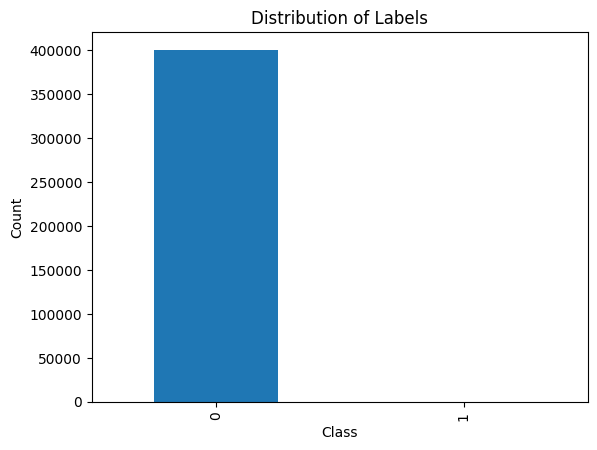

In [25]:
# Get the distribution of the labels
label_distribution = train_df['target'].value_counts()
print(label_distribution)
# Plot the distribution
label_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [26]:
# Assuming your DataFrame is named 'df'
missing_values = test_df.isna()

# To get the count of missing values in each column:
missing_counts = test_df.isna().sum()

# To get the columns containing missing values:
columns_with_missing = test_df.columns[test_df.isna().any()]
columns_with_missing

Index([], dtype='object')

In [27]:
train_df = train_df.drop(['attribution', 'copyright_license'], axis=1)
# y_train = train_df['target']
train_df

,isic_id,target,patient_id,age_approx,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,...,tbp_lv_location_Torso Front Bottom Half,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,ISIC_0015670,0,IP_1235828,0.148184,0.067613,0.380443,-0.257500,-0.659882,-0.192995,-0.407543,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,ISIC_0015845,0,IP_8170065,0.148184,2.935019,2.959584,-0.369545,-0.527265,1.126869,0.906538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0015864,0,IP_6724798,0.148184,0.650540,0.625867,1.835454,1.466075,1.644678,1.385391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,ISIC_0015902,0,IP_4111386,0.517161,-1.433104,-0.780446,-1.294561,-1.291919,-1.583639,-1.355725,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ISIC_0024200,0,IP_8313778,-0.220794,1.188031,1.455843,-0.344179,-0.268248,0.250792,0.349419,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,0.886139,0.650166,0.007202,-0.117160,-0.032541,0.160952,-0.054822,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
401055,ISIC_9999951,0,IP_5678181,0.148184,0.000908,0.313829,1.113374,0.914313,0.838322,0.825604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
401056,ISIC_9999960,0,IP_0076153,0.517161,-0.660445,-0.723881,0.296215,-0.092113,-0.047848,-0.347591,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
401057,ISIC_9999964,0,IP_5231513,-2.065682,0.578715,-1.517130,0.028320,0.022136,0.234743,-0.469141,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
test_df = test_df.drop(['attribution', 'copyright_license'], axis=1)
# y_train = train_df['target']
test_df

,isic_id,patient_id,age_approx,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_location_Torso Front Bottom Half,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,ISIC_0015657,IP_6074337,-0.958749,0.707672,1.441620,0.019401,0.029138,0.284448,0.562959,-0.621776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,ISIC_0015729,IP_1664139,-1.696704,-0.831441,-1.490710,0.575110,0.136361,0.119378,-0.362720,1.331464,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0015740,IP_7142616,0.517161,1.070096,1.421817,0.413357,0.328180,0.727544,0.779689,-0.575810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
train_df.dtypes

isic_id                                object
target                                  int64
patient_id                             object
age_approx                            float32
tbp_lv_A                              float32
                                       ...   
tbp_lv_location_simple_Right Arm      float32
tbp_lv_location_simple_Right Leg      float32
tbp_lv_location_simple_Torso Back     float32
tbp_lv_location_simple_Torso Front    float32
tbp_lv_location_simple_Unknown        float32
Length: 65, dtype: object

In [30]:
from collections import namedtuple

CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, isic_id, patient_id, attributes',
)


def getCandidateInfoList(df, is_train=True, requireOnDisk_bool=True):
    candidateInfo_list = []

    # Define columns to drop based on whether it's train or test DataFrame
    if is_train:
        columns_to_drop = ['isic_id', 'target', 'patient_id']
    else:
        columns_to_drop = ['isic_id', 'patient_id']

    # Iterate over each row in the dataframe
    for _, row in df.iterrows():
        # Drop unnecessary columns to get attributes
        attributes = row.drop(columns_to_drop).tolist()

        # Wrap each attribute in a single-element list
        attributes = [[attr] for attr in attributes]

        # Determine the value of isNodule_bool, if 'target' exists
        isNodule_bool = row['target'] if 'target' in df.columns else None

        # Append the CandidateInfoTuple to the list
        candidateInfo_list.append(CandidateInfoTuple(
            isNodule_bool=isNodule_bool,
            isic_id=row['isic_id'],
            patient_id=row['patient_id'],
            attributes=attributes,
        ))

    # Sort the candidate info list in reverse order
    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list



# Usage example:
# metadata_df = pd.read_csv('train_metadata.csv')
# candidates = getCandidateInfoList()
# print(candidates[0])  # Modify as needed

In [31]:
class Img:
    """
    This class represents an image from an HDF5 file.

    Attributes:
        isic_id (str): The ISIC ID of the image in the HDF5 file.
        image_data (bytes): The raw image data loaded from the HDF5 file.
        image_array (np.ndarray): The image data as a NumPy array (assuming RGB format).
        shape (tuple): The shape of the image array (height, width, channels).

    Raises:
        ValueError: If the provided ISIC ID is not found in the HDF5 file.
    """

    def __init__(self, isic_id, img_path, transform=None):
        """
        Initializes the IMG object.

        Args:
            isic_id (str): The ISIC ID of the image in the HDF5 file.
        """

        # Open the HDF5 file in read mode
        with h5py.File(img_path, 'r') as f:
            try:
                # Access the dataset using the ISIC ID
                dset = f[isic_id]

                # Read the entire dataset content (assuming it holds the image data)
                self.image_data = dset[()]

                # Create an in-memory file-like object
                image_data_io = io.BytesIO(self.image_data)

                # Open the image using Pillow
                self.image = Image.open(image_data_io)

                 # Apply the transformations to the image if transform is True
                if transform:
                    self.image = transform(self.image)
                
                # Convert the image to a NumPy array
                self.image_array = np.array(self.image)

                # Get the image shape
#                 self.shape = self.image_array.shape

            except KeyError:
                raise ValueError(f"ISIC ID '{isic_id}' not found in 'train-image.hdf5'")

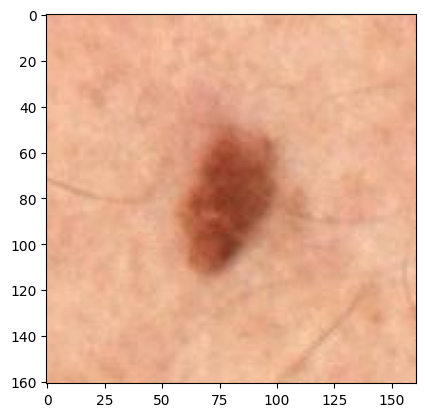

In [32]:
import matplotlib.pyplot as plt

# Create an instance of the Img class
img = Img(isic_id='ISIC_9999937', img_path=path + 'train-image.hdf5')

# Display the image
plt.imshow(img.image)
plt.show()

In [33]:

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize the image to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally (data augmentation)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor
])



# Fit the scaler on your training set
scaler = StandardScaler()

In [34]:


# def save_images(ids, hdf5_path, save_dir, transform=None, save_as='png'):
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

#     for isic_id in ids:
#         img = Img(isic_id, hdf5_path, transform)

#         if save_as == 'png':
#             save_path = os.path.join(save_dir, f"{isic_id}.png")
#             img.image.save(save_path)
#         elif save_as == 'npy':
#             save_path = os.path.join(save_dir, f"{isic_id}.npy")
#             np.save(save_path, np.array(img.image))

In [35]:
# Get the list of CandidateInfoTuple
# candidate_info_list_test = getCandidateInfoList(test_df)

# # Extract ISIC IDs
# ids_test = [candidate.isic_id for candidate in candidate_info_list_test]

In [36]:
# save_images(ids_test, path + 'test-image.hdf5', save_dir='/kaggle/working/test/images_test_npy', transform=transform, save_as='npy')

In [37]:

# def load_npy(isic_id, img_path):
#     return np.load(os.path.join(img_path, f"{isic_id}.npy"), mmap_mode='r')


def load_npy(isic_id, img_path):
    """
    Load the .npy file corresponding to the given ISIC ID.

    Args:
        isic_id (str): The ISIC ID of the image.
        img_path (str): The directory path where the .npy files are stored.

    Returns:
        np.ndarray: The loaded image data.
    """
    file_path = os.path.join(img_path, f"{isic_id}.npy")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    return np.load(file_path)

In [38]:


class ImgDataset(Dataset):
  def __init__(self,
               val_stride=0,
               isValSet_bool=None,
               isic_id=None,
               img_path = None,
               sortby_str = 'random',
               ratio_int=0,
               is_train=None,
               transform=None,
              ):
    self.is_train = is_train
    self.imgInfo_list = copy.copy(getCandidateInfoList(train_df, is_train=self.is_train))
    self.ratio_int = ratio_int
    self.transform = transform
    self.img_path = img_path

    if isic_id:
      self.imgInfo_list = [
        x for x in self.imgInfo_list if x.isic_id == isic_id
      ]

    if isValSet_bool:
      assert val_stride > 0, val_stride
      self.imgInfo_list = self.imgInfo_list[::val_stride]
      assert self.imgInfo_list
    elif val_stride > 0:
      del self.imgInfo_list[::val_stride]
      assert self.imgInfo_list

    if sortby_str == 'random':
            random.shuffle(self.imgInfo_list)

    log.info("{!r}: {} {} samples".format(
      self,
      len(self.imgInfo_list),
      "validation" if isValSet_bool else "training",
    ))

    self.negative_list = [
            nt for nt in self.imgInfo_list if not nt.isNodule_bool
        ]
    self.pos_list = [
            nt for nt in self.imgInfo_list if nt.isNodule_bool
        ]

  def shuffleSamples(self):
    if self.ratio_int:
      random.shuffle(self.negative_list)
      random.shuffle(self.pos_list)

  def __len__(self):
    if self.ratio_int:
      return 200000
#       return 10000
    else:
      return len(self.imgInfo_list)


#   @functools.lru_cache(maxsize=1)
  def __getitem__(self, ndx):
    # imgInfo_tup = self.imgInfo_list[ndx]

    if self.ratio_int:
      pos_ndx = ndx // (self.ratio_int + 1)
      if ndx % (self.ratio_int + 1):
        neg_ndx = ndx-1- pos_ndx
        neg_ndx %= len(self.negative_list)
        imgInfo_tup = self.negative_list[neg_ndx]
      else:
        pos_ndx %= len(self.pos_list)
        imgInfo_tup = self.pos_list[pos_ndx]
    else:
      imgInfo_tup = self.imgInfo_list[ndx]

    # Load the image using the ISIC ID
#     img_t = Img(imgInfo_tup.isic_id, self.img_path, self.transform)
    img_t = load_npy(imgInfo_tup.isic_id, self.img_path)


    # Apply the transformations to the image if transform is True
#     if self.transform:
#         img_t = self.transform(img_t.image)


    label = torch.tensor([
                not imgInfo_tup.isNodule_bool,
                imgInfo_tup.isNodule_bool
            ],
            dtype=torch.float,
        )

    # Convert attributes to a PyTorch tensor
    attributes = np.array(imgInfo_tup.attributes)
    # Create a StandardScaler object
#     scaler = StandardScaler()

    # Fit the scaler to the attributes
#     scaler.fit(attributes)

#     attributes = scaler.transform(attributes)
    attributes_t = torch.from_numpy(attributes).to(torch.float32)


    attributes_t = attributes_t.squeeze(-1)

    return (
#         torch.from_numpy(img_t.image_array).to(torch.float32),
      torch.from_numpy(img_t).to(torch.float32),
#       img_t.image,
      imgInfo_tup.isic_id,
      imgInfo_tup.patient_id,
      attributes_t,
      label
    )


In [39]:
# Create an instance of the ImgDataset class
# dataset = ImgDataset(isic_id='ISIC_9999937', img_path= path + 'train-image.hdf5', is_train= True, transform=transform)
img_path = '/kaggle/input/isic-skin-dset/output_images'
dataset = ImgDataset(isic_id='ISIC_9999937', img_path=img_path)

# Print the length of the dataset
print(f'Length of dataset: {len(dataset)}')

# Get the first item in the dataset
item = dataset[0]

# The image is a PyTorch tensor, so we need to convert it to a numpy array
# Also, the image might be in (C, H, W) format, so we need to transpose it to (H, W, C)
# image = item[0].numpy().transpose((1, 2, 0))

# # Display the image
# plt.imshow(image)
# plt.show()

# # Print the different variables
print(f'Image tensor: {item[0].shape}')
# print(f'ISIC ID: {item[1]}')
# print(f'Patient ID: {item[2]}')
print(f'Attributes tensor: {item[3]}')
# # print(f'Label: {item[4]}')
num_attributes = len(item[3])
num_attributes

Length of dataset: 1
Image tensor: torch.Size([3, 48, 48])
Attributes tensor: tensor([ 0.0000,  0.8861,  0.6502,  0.0072, -0.1172, -0.0325,  0.1610, -0.0548,
        -0.7009, -0.0306, -0.5482,  0.1771, -0.2318,  1.9785,  2.4779,  0.0226,
         1.4667, -0.2028,  2.0816,  1.7854,  2.4967, -0.1109,  0.7618,  0.3482,
         0.7597, -0.5519, -1.6527,  0.7575,  2.2880, -0.2008,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000])


63

In [40]:
candidates = getCandidateInfoList(test_df, is_train=False)
print(candidates[0])  # Modify as needed

CandidateInfoTuple(isNodule_bool=None, isic_id='ISIC_0015740', patient_id='IP_7142616', attributes=[[0.51716148853302], [1.0700962543487549], [1.421817421913147], [0.413356751203537], [0.3281795382499695], [0.7275442481040955], [0.7796886563301086], [-0.5758104920387268], [-1.0798232555389404], [-0.595562756061554], [-0.8132621645927429], [0.07090212404727936], [-1.0737371444702148], [-0.8698423504829407], [1.0673013925552368], [-0.9286268949508667], [0.30001300573349], [-1.1589585542678833], [-1.0695399045944214], [-0.9405801892280579], [0.7489414811134338], [-0.41164901852607727], [0.6451132893562317], [-0.9594319462776184], [1.1793862581253052], [1.1446290016174316], [-0.34501907229423523], [-0.9820036888122559], [-0.2007526457309723], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0]])


In [41]:


class TestDataset(Dataset):
  def __init__(self,
               isic_id=None,
               img_path=None,
               is_train = None,
               transform=None,
              ):
    self.is_train = is_train
    self.imgInfo_list = copy.copy(getCandidateInfoList(test_df, self.is_train))
    self.img_path = img_path
    self.transform = transform

    if isic_id:
      self.imgInfo_list = [
        x for x in self.imgInfo_list if x.isic_id == isic_id
      ]

    log.info("{!r}: {} {} samples".format(
      self,
      len(self.imgInfo_list),
      "testing",
    ))


  def __len__(self):
    return len(self.imgInfo_list)

  def __getitem__(self, ndx):
    imgInfo_tup = self.imgInfo_list[ndx]

    # Load the image using the ISIC ID
    img_t = Img(imgInfo_tup.isic_id, self.img_path, transform=transform)
#     img_t = load_npy(imgInfo_tup.isic_id, self.img_path)

    # Apply the transformations to the image if transform is True
#     if self.transform:
#         img_t = self.transform(img_t.image)

    # Convert attributes to a PyTorch tensor
    attributes = np.array(imgInfo_tup.attributes)
    # Create a StandardScaler object
#     scaler = StandardScaler()

    # Fit the scaler to the attributes
#     scaler.fit(attributes)

#     attributes = scaler.transform(attributes)
    attributes_t = torch.from_numpy(attributes).to(torch.float32)
    attributes_t = attributes_t.squeeze(-1)


    return (
      torch.from_numpy(img_t.image_array).to(torch.float32),
      imgInfo_tup.isic_id,
      imgInfo_tup.patient_id,
      attributes_t,
    )

In [42]:
data = TestDataset(isic_id='ISIC_0015657', img_path= path + 'test-image.hdf5', is_train= False, transform=transform)
# img_path_test = '/kaggle/working/test/images_test_npy'
# data = TestDataset(isic_id='ISIC_0015657', img_path=img_path_test)

# Print the length of the dataset
# print(f'Length of dataset: {len(dataset)}')

# Get the first item in the dataset
item = data[0]

# The image is a PyTorch tensor, so we need to convert it to a numpy array
# Also, the image might be in (C, H, W) format, so we need to transpose it to (H, W, C)
# image = item[0].numpy().transpose((1, 2, 0))

# # Display the image
# plt.imshow(image)
# plt.show()

# # Print the different variables
print(f'Image tensor: {item[0].shape}')
# print(f'ISIC ID: {item[1]}')
# print(f'Patient ID: {item[2]}')
print(f'Attributes tensor: {item[3]}')
# # print(f'Label: {item[4]}')
num_attributes = len(item[3])
# num_attributes

Image tensor: torch.Size([3, 48, 48])
Attributes tensor: tensor([-0.9587,  0.7077,  1.4416,  0.0194,  0.0291,  0.2844,  0.5630, -0.6218,
        -1.3302, -1.5933, -1.6598,  0.7134, -0.7986, -0.2893, -0.5337, -0.9282,
         1.1504, -0.9528, -0.9687, -0.8248,  0.0983, -0.7704,  1.1508,  0.6611,
        -0.9565,  1.2304, -0.9894, -0.8397, -0.2008,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000])


In [43]:

print(os.listdir('/kaggle/input/isic-2024-challenge/'))

['sample_submission.csv', 'train-metadata.csv', 'test-metadata.csv', 'test-image.hdf5', 'train-image', 'train-image.hdf5']


In [44]:



class MyModel(nn.Module):
    def __init__(self, num_attributes):
        super(MyModel, self).__init__()

        # Load a pre-trained EfficientNet model
        self.image_model = models.efficientnet_b0()
        self.image_model.load_state_dict(torch.load('/kaggle/input/efficientnet/pytorch/default/1/efficientnet_b0_weights.pth'))

        # Freeze the parameters
        for param in self.image_model.parameters():
            param.requires_grad = False

        # Adjust the last layer based on the output feature of EfficientNet
#         num_features = self.image_model.classifier.in_features  # Use 'classifier' instead of 'fc'
        self.image_model.classifier[1] = nn.Sequential(
            nn.Linear(1280, 128),
            nn.ReLU(inplace=True),
        )
        
        self.attributes_model = nn.Sequential(
            nn.Linear(num_attributes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.fc = nn.Linear(128 + 32, 2)

    def forward(self, image, attributes):
        image_outputs = self.image_model(image)
        attributes_outputs = self.attributes_model(attributes)
        outputs = torch.cat((image_outputs, attributes_outputs), dim=1)
        outputs = self.fc(outputs)
        return outputs

In [45]:
import torch.multiprocessing as mp

# def async_data_loader(loader):
#     for batch in loader:
#         yield batch
        
import torch

def clear_cache():
    torch.cuda.empty_cache()


In [46]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

class ModelTrainer:
    def __init__(self, train_dataset, val_dataset, learning_rate=0.001):
        # Check if CUDA is available and set the device accordingly
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")

        self.early_stopping = EarlyStopping(patience=3, verbose=True)


        # Load a pre-trained ResNet model
#         self.model = models.resnet50(pretrained=True).to(self.device)

        # Create an instance of MyModel
        self.model = MyModel(num_attributes).to(self.device)


        # Define the loss function and the optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        # Create data loaders
        self.train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=self.use_cuda)
        self.val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=self.use_cuda)

    def train_and_evaluate(self, epochs=10):
        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs}')

            # Shuffle the training samples
            self.train_loader.dataset.shuffleSamples()

            # Training phase
            self.train(self.train_loader)

            # Evaluation phase
            val_loss = self.evaluate(self.val_loader)

            # Early stopping check
            self.early_stopping(val_loss, self.model)
            if self.early_stopping.early_stop:
                print("Early stopping")
                break


    def train(self, dataloader):
        self.model.train()
        running_loss = 0.0
        num_correct_neg, total_neg = 0, 0
        num_correct_pos, total_pos = 0, 0

        for images, isc_id, pt_id, att, labels in tqdm(dataloader):
            inputs, labels = images.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
            att = att.to(self.device, non_blocking=True)
            self.optimizer.zero_grad()
            outputs = self.model(inputs, att)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            true_labels = torch.argmax(labels, dim=1)

            # Update counts for positive and negative labels
            # (assuming labels are binary: 0 for negative, 1 for positive)
            num_correct_neg += ((predicted == true_labels) & (true_labels == 0)).sum().item()
            total_neg += (true_labels == 0).sum().item()
            num_correct_pos += ((predicted == true_labels) & (true_labels == 1)).sum().item()
            total_pos += (true_labels == 1).sum().item()

        # Call calculate_metrics function after the loop
        self.calculate_metrics(true_labels, predicted, running_loss, dataloader, num_correct_neg, total_neg, num_correct_pos, total_pos)
        
        # Clear the GPU cache
        clear_cache()

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0.0
        total_samples = 0
        correct = 0
        total = 0
        num_correct_neg, total_neg = 0, 0
        num_correct_pos, total_pos = 0, 0

        with torch.no_grad():
            for images, isc_id, pt_id, att, labels in tqdm(dataloader):
                images, labels = images.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
                att = att.to(self.device, non_blocking=True)
                outputs = self.model(images, att)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item() * images.size(0)
                total_samples += images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                true_labels = torch.argmax(labels, dim=1)
                correct += (predicted == true_labels).sum().item()
                total += labels.size(0)

                # Update counts for positive and negative labels (similar to train)
                num_correct_neg += ((predicted == true_labels) & (true_labels == 0)).sum().item()
                total_neg += (true_labels == 0).sum().item()
                num_correct_pos += ((predicted == true_labels) & (true_labels == 1)).sum().item()
                total_pos += (true_labels == 1).sum().item()
                total_samples += images.size(0)

        # Calculate the average loss over all samples
        avg_loss = total_loss / total_samples

        # Call calculate_metrics function after the loop
        self.calculate_metrics(true_labels, predicted, avg_loss, dataloader, num_correct_neg, total_neg, num_correct_pos, total_pos)
        
        # Clear the GPU cache
        clear_cache()

        # Call the EarlyStopping instance
        self.early_stopping(avg_loss, self.model)
        return avg_loss


    def predict(self, dataloader):
        self.model.eval()
        results = []
        with torch.no_grad():
            for images, isic_id, pt_id, att in tqdm(dataloader):
                images = images.to(self.device, non_blocking=True)
                att = att.to(self.device, non_blocking=True)
                outputs = self.model(images, att)
                # Apply softmax to the outputs to get probabilities
                probs = torch.nn.functional.softmax(outputs, dim=1)
                # Debug prints
                print(f"Outputs: {outputs}")
                print(f"Probabilities: {probs}")

                malignant_probs = probs[:, 1].cpu().numpy()

                # Debug print
                print(f"Malignant Probabilities: {malignant_probs}")
                malignant_probs = np.round(malignant_probs, 1)
                results.extend(zip(isic_id, malignant_probs))

                # Get the maximum probability and its corresponding class
                # max_probs, _ = torch.max(probs, dim=1)
                # Extend the results list with tuples of (isic_id, max_probability)
                # results.extend(zip(isic_id, max_probs.cpu().numpy()))
        return results





    def calculate_metrics(self, true_labels, predicted, running_loss, dataloader, num_correct_neg, total_neg, num_correct_pos, total_pos):
        # Convert tensors to numpy arrays for metric calculation
        true_labels = true_labels.cpu().numpy()
        predicted = predicted.cpu().numpy()

        # Calculate confusion matrix
        cm = confusion_matrix(true_labels, predicted)
        if cm.size == 1:  # Only one class is being predicted
            tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
        else:
            tn, fp, fn, tp = cm.ravel()

        # Calculate precision, recall, and F1 score
        precision = precision_score(true_labels, predicted)
        recall = recall_score(true_labels, predicted)
        f1 = f1_score(true_labels, predicted)

        # Calculate and print losses and accuracies for both negative and positive
        avg_loss = running_loss / len(dataloader)
        acc = 100 * (num_correct_neg + num_correct_pos) / (total_neg + total_pos)
        acc_neg = 100 * (num_correct_neg / total_neg) if total_neg > 0 else 0.0
        acc_pos = 100 * (num_correct_pos / total_pos) if total_pos > 0 else 0.0

        print(f'Epoch loss: {avg_loss}')
        print(f'Accuracy: {acc:.2f}% ({num_correct_neg} of {total_neg} negative, {num_correct_pos} of {total_pos} positive)')

        # Print the metrics
        print(f'TN={tn}, FP={fp}, FN={fn}, TP={tp}, Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}')


#     def save_model(self, path):
#         torch.save(self.model.state_dict(), path)


In [47]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [48]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. CPU is being used.")


Tesla P100-PCIE-16GB


In [49]:


balanced = True
# Create instances of the ImgDataset class for training and validation
train_dataset = ImgDataset(val_stride=10, isValSet_bool=False,
                           img_path=img_path, ratio_int=int(balanced), is_train= True)
val_dataset = ImgDataset(val_stride=10, isValSet_bool=True,
                         img_path=img_path, is_train= True)

# Create a ModelTrainer instance
model_trainer = ModelTrainer(train_dataset, val_dataset, learning_rate=0.001)

# Create data loaders
#     model_trainer.create_data_loaders(train_dataset, val_dataset, batch_size=32)

Train and evaluate the model
model_trainer.train_and_evaluate(epochs=10)


In [50]:
# Save the model (optional)
# model_trainer.save_model('_model.pth')

In [51]:
# Load the test dataset
# img_path = '/kaggle/working/test/images_test_npy'
# img_path= path + 'test-image.hdf5'
# test_dataset = TestDataset(img_path=img_path, transform=transform)

# # Create a DataLoader for the test dataset
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=model_trainer.use_cuda)

# # Predict using the test dataset
# predictions = model_trainer.predict(test_loader)

In [52]:
# Convert the predictions to a DataFrame
# df = pd.DataFrame(predictions, columns=['isic_id', 'target'])
# print(df)

In [53]:
# Save the DataFrame to a CSV file
# df.to_csv('submission.csv', index=False)

In [54]:
# Create an instance of the Img class
# img = Img(isic_id='ISIC_0015657', img_path=path + 'test-image.hdf5')

# # Display the image
# plt.imshow(img.image)
# plt.show()

In [55]:
# import pkg_resources

# for d in pkg_resources.working_set:     print(d)

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
# img_path = '/kaggle/working/test/images_test_npy'
img_path= path + 'test-image.hdf5'
test_dataset = TestDataset(img_path=img_path, is_train= False,transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=model_trainer.use_cuda)
# Initialize your model and device
model = MyModel(num_attributes).to(device)

# Load the saved model
model.load_state_dict(torch.load('/kaggle/input/isic_model/pytorch/default/1/checkpoint.pt'))
model.eval()

# Create an instance of the ModelTrainer class
trainer = ModelTrainer(train_dataset, val_dataset)

# Use the predict function with your test DataLoader
predictions = trainer.predict(test_loader)

predictions

100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

Outputs: tensor([[-0.0616, -0.0275]], device='cuda:0')
Probabilities: tensor([[0.4915, 0.5085]], device='cuda:0')
Malignant Probabilities: [0.50853026]
Outputs: tensor([[ 0.0683, -0.0791]], device='cuda:0')
Probabilities: tensor([[0.5368, 0.4632]], device='cuda:0')
Malignant Probabilities: [0.4632067]
Outputs: tensor([[-0.0393,  0.0279]], device='cuda:0')
Probabilities: tensor([[0.4832, 0.5168]], device='cuda:0')
Malignant Probabilities: [0.5167985]


[('ISIC_0015740', 0.5), ('ISIC_0015729', 0.5), ('ISIC_0015657', 0.5)]

In [58]:
df = pd.DataFrame(predictions, columns=['isic_id', 'target'])

In [59]:
df.to_csv('submission.csv', index=False)